In [1]:
import matplotlib.pyplot as plt
from scipy.special import binom

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford

from wave_expansion import *
from tests.test_wave_expansion import *
from experiments_utils import *

import os
import dill

import networkx as nx

# Auxiliary

In [2]:
def save_experiment(experiment, save_to=None):
    if experiment.save_to:
        save_to=experiment.save_to
    os.makedirs(os.path.dirname(save_to), exist_ok=True)
    with open(save_to, 'wb') as f:
        dill.dump(experiment, f)
        
def load_experiment(load_from):
    with open(load_from, 'rb') as f:
        return dill.load(f)

class NodeDistributionExperiment:
    def __init__(self, num_qubits, num_paulis, num_samples, save_to=None):
        self.num_qubits = num_qubits
        self.num_paulis = num_paulis
        self.num_samples = num_samples
        self.all_node_samples = None
        if save_to is None:
            save_to = f'results/NDE_{num_qubits}_{num_paulis}_{num_samples}'
        self.save_to = save_to
        
    def run(self, seed=0):
        all_node_samples = []
        
        np.random.seed(seed)
        seeds = np.random.randint(0, 10**6, size=self.num_samples+1)
        
        for seed in tqdm(seeds[:-1]):

            pauli_circuit = PauliCircuit.random(self.num_qubits, self.num_paulis, seed=seed)
            observable = random_pauli(self.num_qubits, seed=seeds[-1])

            fourier_computation = FourierComputation(pauli_circuit, observable)
            fourier_computation.run(check_admissible=False, verbose=False)

            all_node_samples.append(fourier_computation.order_statistics())
        
        self.all_node_samples = np.array(all_node_samples)  
        
    def node_stats(self):
        M = self.num_paulis   
        normilized_node_samples = self.all_node_samples / (3/2)**M

        node_means = np.mean(normilized_node_samples, axis=0)
        node_variations = np.std(normilized_node_samples, axis=0)
        
        return node_means, node_variations
    
    def norm_stats(self):
        M = self.num_paulis   
        all_norm_samples = self.all_node_samples * 2.**(-np.arange(M+1))

        norm_means = np.mean(all_norm_samples, axis=0)
        norm_variations = np.std(all_norm_samples, axis=0)
        
        return norm_means, norm_variations
    
    def plot(self):
        M = self.num_paulis   
        
        node_means, node_variations = self.node_stats()
        norm_means, norm_variations = self.norm_stats()
        
        c_node = 'blue'
        c_norm = 'orange'
        
        plt.plot(range(M+1), node_means, color=c_node);
        plt.plot(range(M+1), norm_means, color=c_norm);

        plt.plot(range(M+1), random_node_distribution(M), color=c_node, linestyle='--')
        plt.plot(range(M+1), random_norm_distribution(M), color=c_norm, linestyle='--')
        
        plt.fill_between(range(M+1), node_means-node_variations, node_means+node_variations, alpha=0.75, color=c_node);
        plt.fill_between(range(M+1), norm_means-norm_variations, norm_means+norm_variations, alpha=0.75, color=c_norm);
        
        plt.title(f'num_qubits={self.num_qubits}, num_paulis={self.num_paulis}, num_samples={self.num_samples}')
        
class QAOA:
    def __init__(self, graph, num_layers):
        self.graph = graph
        self.num_qubits = len(graph.nodes)        
        self.num_layers = num_layers
    
    def circuit(self):
        qc = QuantumCircuit(self.num_qubits)
        
        # Hadamard gates
        for n in range(qc.num_qubits):
            qc.h(n)
                
        for p in range(self.num_layers):
            self.add_layer(qc, p)
        
        return qc
    
    def observables(self):
        
        labels = []
        for edge in self.graph.edges:
            i, j = edge
            label = ['I']*self.num_qubits
            label[i] = 'Z'
            label[j] = 'Z'
            labels.append(''.join(label))
            
        return [Pauli(label) for label in labels]
            
    
    def add_layer(self, qc, p):
        x_parameters = [Parameter(f'x_{p}_{n}') for n in range(self.num_qubits)]
        z_parameters = [Parameter(f'z_{p}_{e}') for e in range(len(self.graph.edges))]
        
        for n, x in enumerate(x_parameters):
            qc.rx(x, n)
            
        for edge, z in zip(self.graph.edges, z_parameters):
            i, j = edge
            qc.rzz(z, i, j)
            
            
def local_circuit(num_qubits, num_paulis):
    
    missing_parameters = num_paulis % 4
    parameters0 = [Parameter(f'x_0{i}') for i in range(2*num_qubits)]
    parameters = [Parameter(f'x{i}') for i in range(num_paulis)] + [0]*missing_parameters
    blocks = int(len(parameters) / 4)
    
    qc = QuantumCircuit(num_qubits)
    
    for n in range(num_qubits):
        qc.rx(parameters0[n], n)
        qc.rz(parameters0[num_qubits+n], n)
    
    n = 0
    for b in range(blocks):
        p = parameters[b*4:(b+1)*4]
        
        n0 = n
        n1 = (n+1) % num_qubits
        
        qc.cz(n0, n1)
        if p[0]:
            qc.rx(p[0], n0)
        if p[1]:
            qc.rz(p[1], n0)
        if p[2]:
            qc.rx(p[2], n1)
        if p[3]:
            qc.rz(p[3], n1)
            
        n = (n+1) % num_qubits
    
    return qc    

# Filter scaling

In [ ]:
class DepthScalingExperiment:
    
    def __init__(self, n_range, k_range, num_samples):
        self.n_range = n_range
        self.k_range = k_range
        self.num_samples = num_samples
        self.save_to=f'results/K_vs_{n_range[-1]}_{k_range[-1]}'
        
    def run(self):
        node_stats = {n:{} for n in self.n_range}
        for n in tqdm(self.n_range):
            for k in self.k_range:
                all_non_zero_nodes = []
                for seed in range(self.num_samples):
                    fourier_computation = FourierComputation.random(n, n+k, seed=seed)
                    fourier_computation.run(verbose=False)
                    non_zero_nodes = len([node for node in fourier_computation.complete_nodes if node.expectation_value != 0])
                    all_non_zero_nodes.append(non_zero_nodes)
                
                node_stats[n][k] = sum(all_non_zero_nodes)/len(all_non_zero_nodes)
        
        self.stats = node_stats
        return node_stats
    
    def plot(self, v_min = 0.1, v_max = 5):
        data = [(n, k, self.stats[n][k]) for n in self.n_range for k in self.k_range if v_min<self.stats[n][k]<v_max]
        x, y, v = list(zip(*data))

        plt.scatter(x, y, c=v)
        plt.xlabel('N')
        plt.ylabel('K')
        plt.colorbar()

In [57]:
fourier_computation = FourierComputation.random(25, 45, seed=2)
fourier_computation.run()

 73%|██████████████████████████████████████████████▏                | 33/45 [00:07<00:02,  4.20it/s, (relative: 100.00%, absolute: 2.4e-07, remaining: 0)]


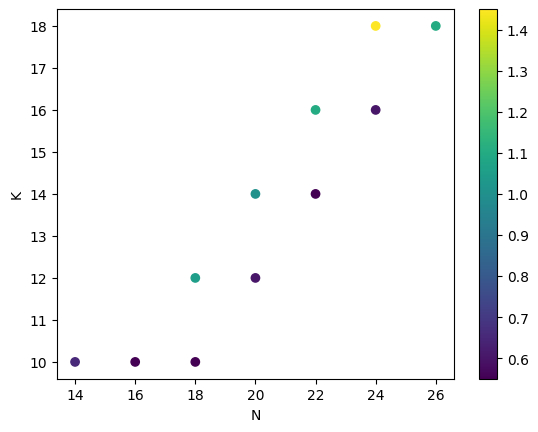

In [46]:
exp.plot(v_min=0.5,v_max=1.5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [35:37<00:00, 106.85s/it]


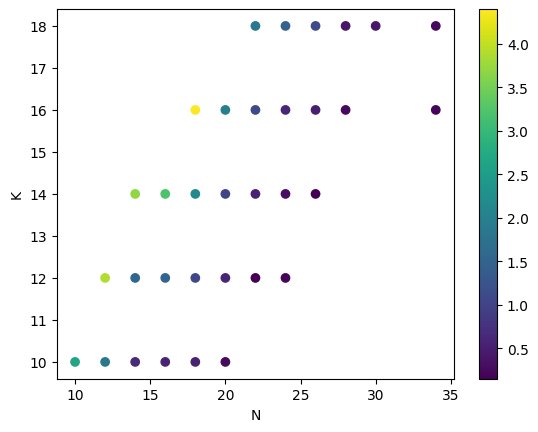

In [34]:
exp = DepthScalingExperiment(range(10, 50, 2), range(10, 20, 2), 20)
exp.run()

save_experiment(exp)

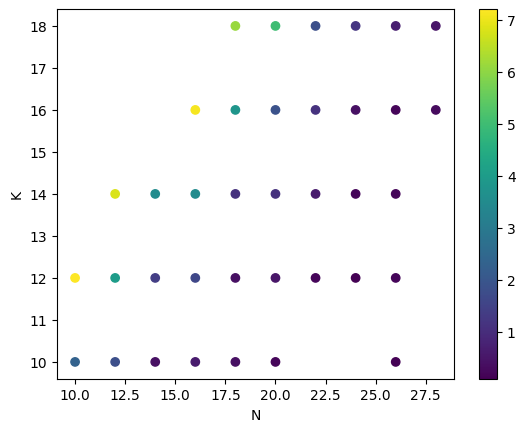

In [32]:
stats = exp.stats
data = [(n, k, stats[n][k]) for n in exp.n_range for k in exp.k_range if 0<exp.stats[n][k]<10]
x, y, v = list(zip(*data))

plt.scatter(x, y, c=v)
plt.xlabel('N')
plt.ylabel('K')
plt.colorbar()

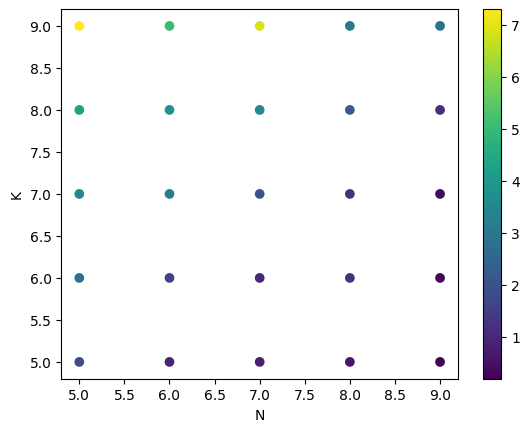

# QAOA

In [5]:
observable = CoarsePauli(5, 4, 0)
pauli = CoarsePauli(5, 2, 1)

print(NodeDistribution.from_observable_and_pauli(observable, pauli).counts_array)

[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.48 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [1.   0.32 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]]


In [6]:
observables[0]

Pauli('IIIIIZIIZI')

In [7]:
pauli_circuit.paulis[-1]

Pauli('IIIIIIIXIX')

In [19]:
1.1**20

6.727499949325611

In [21]:
num_qubits = 20
degree = 8
level = 2


graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

qc = qaoa.circuit()
observables = qaoa.observables()

pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)
random_local_circuit = RandomLocalCircuit.from_pauli_circuit(pauli_circuit)

print(len(pauli_circuit.paulis))
print(len(observables))

for observable in observables[:5]:
    fourier_computation = FourierComputation(pauli_circuit, observable)
    fourier_computation.run(check_admissible=False)
    print(len(fourier_computation.complete_nodes))
    
    node_distribution, history = random_local_circuit.estimate_node_count(CoarsePauli.from_pauli(observable.evolve(pauli_circuit.final_clifford)))
    print(node_distribution.counts_array.sum())
    print(history)

200
80


 12%|██████▊                                               | 25/200 [12:06:42<84:46:55, 1744.09s/it, (relative: 5.61%, absolute: 0.002, remaining: 0.033)]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23338/1873294849.py", line 20, in <module>
    fourier_computation.run(check_admissible=False)
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/wave_expansion.py", line 357, in run
    for _ in progress_bar:
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/wave_expansion.py", line 371, in iteration
    samples = [  ]
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/wave_expansion.py", line 534, in branch_and_refine
    nodes.append(self.branch_cos(pauli_space))
  File "/home/idnm/Dropbox/hep/Sheets/Quantum Computing/slow_waves_conjecture/wave_expansion.py", line 446, in is_complete
  File "/home/idnm/Dropbox/hep/Sheets/Quant

Example.

## Pushing N to the limit

In [39]:
num_qubits = 128
degree = 10
level = 1

graph = nx.random_regular_graph(degree, num_qubits, seed=41)
qaoa = QAOA(graph, level)

pauli_circuit = PauliCircuit.from_parameterized_circuit(qaoa.circuit())
observables = qaoa.observables()

for observable in observables:
    fourier_computation = FourierComputation(pauli_circuit, observables[0])
    fourier_computation.run()

  0%|                                                                             | 0/768 [00:00<?, ?it/s, (relative: 100.00%, absolute: 0, remaining: 0)]


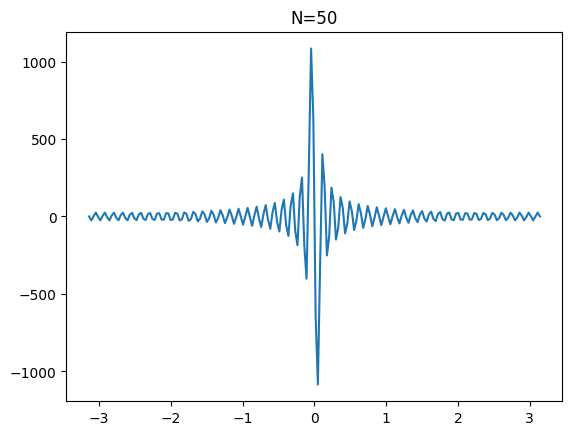

In [38]:
x = np.linspace(-np.pi, np.pi, 200)

def vals(N):
    return -sum([np.cos(n*x) for n in range(N+1)])

def grads(N):
    return -sum([n*np.sin(n*x) for n in range(N+1)])

# for N in [1, 4, 10, 30]:
N=50
plt.plot(x, grads(N))
plt.title(f'N={N}')
plt.savefig(f'results/N={N}.png')

# Random circuits

## Node and norm stats

100%|███████████████████████████████████████████| 20/20 [02:18<00:00,  6.95s/it]


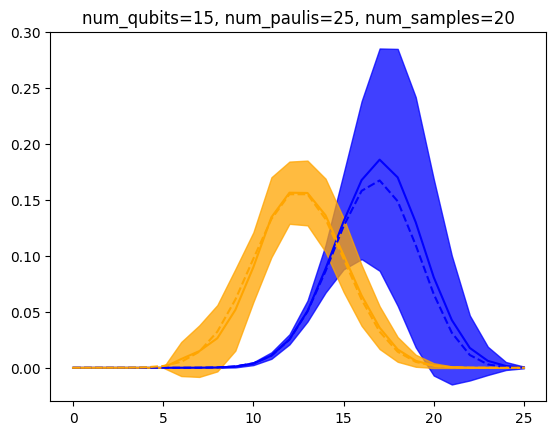

In [4]:
fourier_computationriment = NodeDistributionExperiment(15, 25, 20)
experiment.run()
save_experiment(experiment)

experiment.plot()

## Which observables contribute?

In [85]:
num_qubits = 30
num_paulis = 60

fourier_computation = FourierComputation.random(num_qubits, num_paulis)
fourier_computation.run()

print([node.observable for node in fourier_computation.complete_nodes if node.expectation_value != 0])

 80%|██████████████████████████████████████████████████▍            | 48/60 [08:07<02:01, 10.16s/it, (relative: 100.00%, absolute: 1.1e-10, remaining: 0)]

[Pauli('-ZZZZZZIZIZIZIIZIIIZIIZZIIZIZIZ'), Pauli('IIIZZIZZZZZIIIIZIIZZIZIIZIZIZZ'), Pauli('-IZIZZZIIZIZIZIZIZZIZIIIIIZZZII'), Pauli('ZIZIIIZIZZZIZZIIZIIZZIZZIIZZZI'), Pauli('-IIIIZIIIZZIIIZZZIIZZIIIZIIZZZZ'), Pauli('ZIZIIZIIZZIZIZIIZZZIZIIZZZZIII'), Pauli('IZIIZIZZZZIZZZIIIIZZZIIIIZIZZI'), Pauli('-IZZIZZZZZZIIZZZZIIIIIIIZIIIIIZ'), Pauli('-ZZZZZZZZZIZZZIZZZZIZIZIZZIIZZZ'), Pauli('-ZIZIIIZIZZZIZZIIZIIZZIZZIIZZZI'), Pauli('-IIIIIZIIZIZZIZIIIIZIZZIIZIIZZZ'), Pauli('ZZIIIIIZZIZIIZIZIZZIIZZIZZIIZI'), Pauli('-ZZIZIIIZZZIIZIIZZZIZZIIZZIZIZI'), Pauli('IZIZIZIZZZIZZZZIZIZIZIZZZZIZZZ'), Pauli('-ZZIZZZZZIZIZZZZZIZZZIZIZIZZZZZ'), Pauli('ZZIZZZZIZIIZZIIIIZIZZIZZIIZIIZ'), Pauli('-ZIIZZZZZIIZZZIIIZZIIZIZIIZZIII'), Pauli('ZIIIZIZIZZZZIZIIZZZZIZIZZIIZIZ'), Pauli('IZIZIZIIZZZIIZZZIZIIIIZZZIIZZI'), Pauli('IZZIZIZIZIZZIZIZIZIIIIIZIIZZZI'), Pauli('ZIZIZZIIIZIZIZIIZZZIIIIZZIIIZI'), Pauli('-ZIIIZIZIZZZZIZIIZZZZIZIZZIIZIZ'), Pauli('ZZZZIIIZIIZIZZZIZIZZIZZZIIZIZZ'), Pauli('ZIIIZZIIZZZIZIZZIIZZZIIZIIZIZZ'), Paul

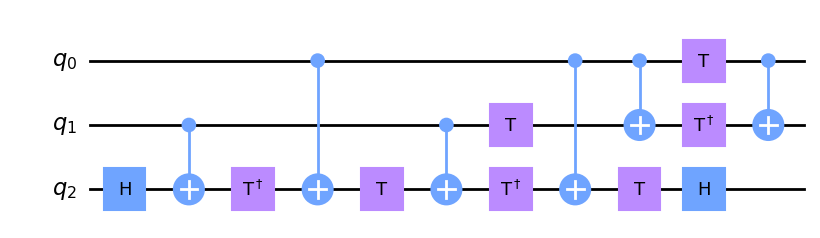

In [87]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw(output='mpl')

In [ ]:
qc_new = QuantumCircuit(3)
data_new = []
for gate, qargs, cargs:
    if gate.name in ['t', 'tdg']:
        new_gate = 
    

# Hardware-efficient circuits

### 

In [74]:
num_qubits=4

SparsePauliOp.from_operator(DensityMatrix(Statevector(QuantumCircuit(num_qubits))).to_operator())

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII', 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ'],
              coeffs=[0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j,
 0.0625+0.j, 0.0625+0.j, 0.0625+0.j, 0.0625+0.j])

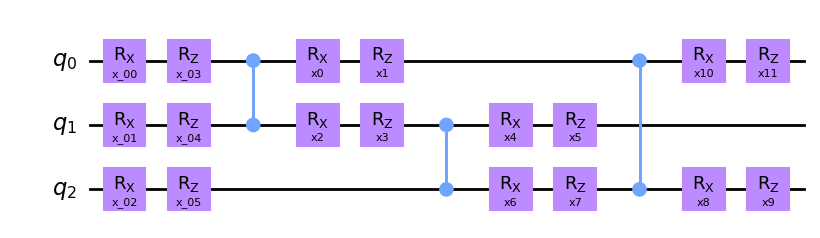

In [77]:
local_circuit(3, 12).draw(output='mpl')

In [78]:
pqc = local_circuit(50, 300)

pauli_circuit = PauliCircuit.from_parameterized_circuit(pqc)
observable = Pauli('XX'+'I'*(pqc.num_qubits-2))

fourier_computation = FourierComputation(pauli_circuit, observable)
fourier_computation.run(check_admissible=False)

  7%|███▉                                                      | 27/400 [44:20<10:12:31, 98.53s/it, (relative: 89.17%, absolute: 0.06, remaining: 0.0073)]


KeyboardInterrupt: 

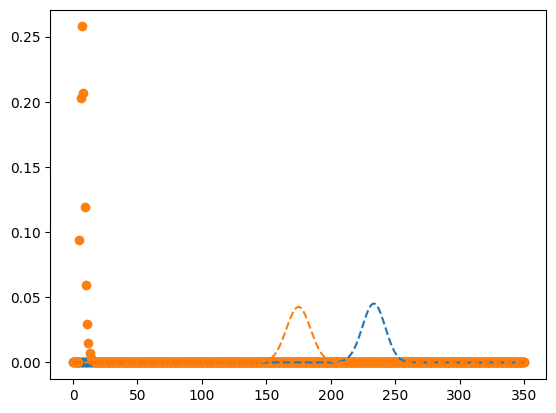

In [60]:
fourier_computation.visualize()